Exploratory topic analysis
1. What are the most covered topics?
2. Changes over time
3. Covid impact?

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
plt.style.use('lenk')

In [3]:
files = glob.glob('data-sent/news-eng-lemmatized-*.csv')
len(files) # 6 years x 12 months

72

In [4]:
usecols = ['id', 'url', 'publishDate', 'headingEngLemma', 'leadEngLemma', 'articleTextEngLemma', 'compound']
df_list = []

for f in files:
    df_list.append(pd.read_csv(f, usecols=usecols))
    
df = pd.concat(df_list, ignore_index=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257731 entries, 0 to 257730
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   257731 non-null  int64  
 1   publishDate          257731 non-null  object 
 2   url                  257731 non-null  object 
 3   headingEngLemma      257607 non-null  object 
 4   leadEngLemma         255446 non-null  object 
 5   articleTextEngLemma  257494 non-null  object 
 6   compound             257731 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 13.8+ MB


In [6]:
for column in [c for c in df.columns if 'Lemma' in c]:
    df.loc[df[column]=='go wrong'] = ''
    df.loc[df[column].isna()] = ''

df['full_text'] = (df['headingEngLemma'] + ' ' + df['leadEngLemma'] + ' ' + df['articleTextEngLemma']).str.strip()
df = df.loc[df['full_text']!='']

df.drop(columns=['headingEngLemma', 'leadEngLemma', 'articleTextEngLemma'], inplace=True)

In [7]:
df['publishDate'] = pd.to_datetime(df['publishDate'])
df['publishDt'] = pd.to_datetime(df['publishDate'].dt.date)
df = df.loc[df['publishDt']>='2016-01-01']
df['publishWeekDt'] = df['publishDt'] - df['publishDt'].dt.weekday * np.timedelta64(1, 'D')
df['publishMonthDt'] = df['publishDt'].dt.to_period('M').dt.to_timestamp()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254430 entries, 0 to 257730
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              254430 non-null  object        
 1   publishDate     254430 non-null  datetime64[ns]
 2   url             254430 non-null  object        
 3   compound        254430 non-null  object        
 4   full_text       254430 non-null  object        
 5   publishDt       254430 non-null  datetime64[ns]
 6   publishWeekDt   254430 non-null  datetime64[ns]
 7   publishMonthDt  254430 non-null  datetime64[ns]
dtypes: datetime64[ns](4), object(4)
memory usage: 17.5+ MB


In [9]:
df.head()

,id,publishDate,url,compound,full_text,publishDt,publishWeekDt,publishMonthDt
0,1129895,2020-09-01 12:40:00,https://www.err.ee/1129895,0.0,pm directly news house põlluaas kaljulaid gues...,2020-09-01,2020-08-31,2020-09-01
1,1129749,2020-09-01 07:02:00,https://sport.err.ee/1129749,0.8885,cannabis return open huge victory second world...,2020-09-01,2020-08-31,2020-09-01
2,1129994,2020-09-01 20:57:00,https://sport.err.ee/1129994,0.9689,estonian football team gather tuesday estonian...,2020-09-01,2020-08-31,2020-09-01
3,1129993,2020-09-01 20:35:00,https://sport.err.ee/1129993,0.6127,buy young brazilian defender london arsenal fo...,2020-09-01,2020-08-31,2020-09-01
4,1129995,2020-09-01 20:07:00,https://www.err.ee/1129995,0.9655,also have live virus vaccine expert spring war...,2020-09-01,2020-08-31,2020-09-01


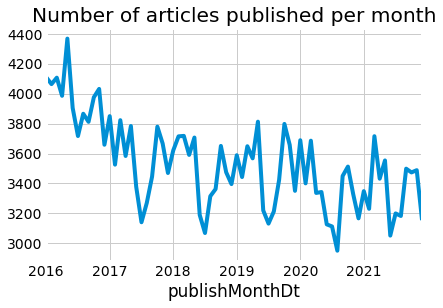

In [10]:
df.groupby('publishMonthDt')['id'].count().plot()
plt.title('Number of articles published per month')
plt.show()

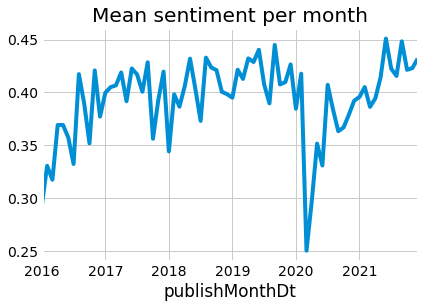

In [11]:
df.groupby('publishMonthDt')['compound'].mean().plot()
plt.title('Mean sentiment per month')
plt.show()

# Preprocessing

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

In [14]:
X = tfidf.fit_transform(df['full_text']) # document-term matrix

# Modelling

In [15]:
from sklearn.decomposition import NMF

In [16]:
n_topics = 15
nmf_model = NMF(n_components=n_topics, init='nndsvda', random_state=42)

In [17]:
W = nmf_model.fit_transform(X)
H = nmf_model.components_

In [18]:
df['topic'] = W.argmax(axis=1)

In [19]:
df['topic'].value_counts()/len(df)*100

6     14.257753
5     10.631215
0     10.222851
11     9.596746
9      8.144087
2      7.298668
8      6.534214
12     5.506033
14     5.194749
4      4.815863
10     4.775773
1      4.105648
13     3.837205
7      3.130527
3      1.948670
Name: topic, dtype: float64

# The top words for each topic
To understand what the topics are about

In [20]:
n = 15

print(f'Top {n} words per topic')
print()

for index, topic in enumerate(H):
    top_words = ' '.join([tfidf.get_feature_names()[i] for i in topic.argsort()[-n:]])
    print(f'{index}: {top_words}')

Top 15 words per topic

0: thing know make museum estonian think life time book say theater art people exhibition work
1: home victory throw assist eye loss ball rebound table game basketball quarter win score point
2: singer video record new musician estonian dance release band perform album festival concert song music
3: sleet island warm day gust night meter air coast cloudy weather rain wind temperature degree
4: rata minister political member candidate government vote coalition support chairman riigikogu center reform election party
5: time estonian start medal olympic finish rally competition win world second stage championship place race
6: security united union government foreign defense russian country russia european state trump say president minister
7: premiere viewer program character feature actor award movie story screen documentary director festival cinema film
8: year sport basketball championship head football league estonian play season player game club coach team
9:

In [21]:
# df.loc[df['topic']==0].sample(10)['url']

In [22]:
# basketball - basketball games
# other sports - track and field, skiing, ralley, etc
# sports general - someone switching a team, getting injured, new coach etc
# football - football matches

topic_labels = ['culture', 'basketball', 'music', 'weather', 'politics', 'other sports', 'foreign politics', 
                'film', 'sports general', 'crime', 'tennis', 'economy', 'healthcare', 'education', 'football']
topics_dict = dict(zip(range(n_topics),topic_labels))

df['topic_label'] = df['topic'].map(topics_dict)

In [23]:
df['topic_label'].value_counts()/len(df)*100

foreign politics    14.257753
other sports        10.631215
culture             10.222851
economy              9.596746
crime                8.144087
music                7.298668
sports general       6.534214
healthcare           5.506033
football             5.194749
politics             4.815863
tennis               4.775773
basketball           4.105648
education            3.837205
film                 3.130527
weather              1.948670
Name: topic_label, dtype: float64

# Analysis

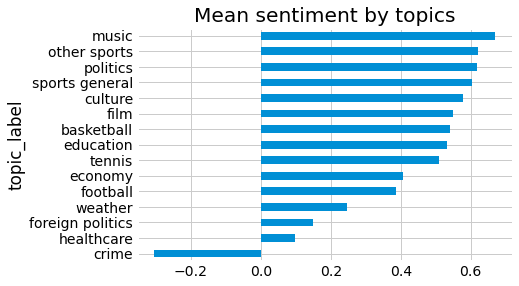

In [24]:
plt.figure(figsize=(6, 4))
df.groupby('topic_label')['compound'].mean().sort_values().plot(kind='barh')
plt.title('Mean sentiment by topics')
plt.show()

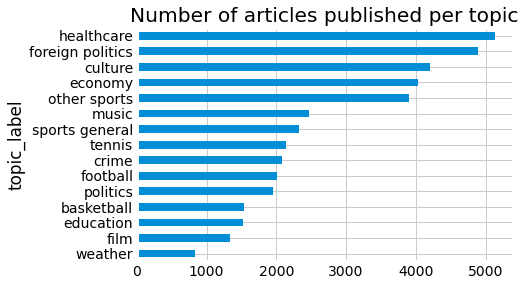

In [25]:
plt.figure(figsize=(6, 4))
df.loc[df['publishDt'].dt.year==2021].groupby('topic_label')['id'].count().sort_values().plot(kind='barh')
plt.title('Number of articles published per topic')
plt.show()

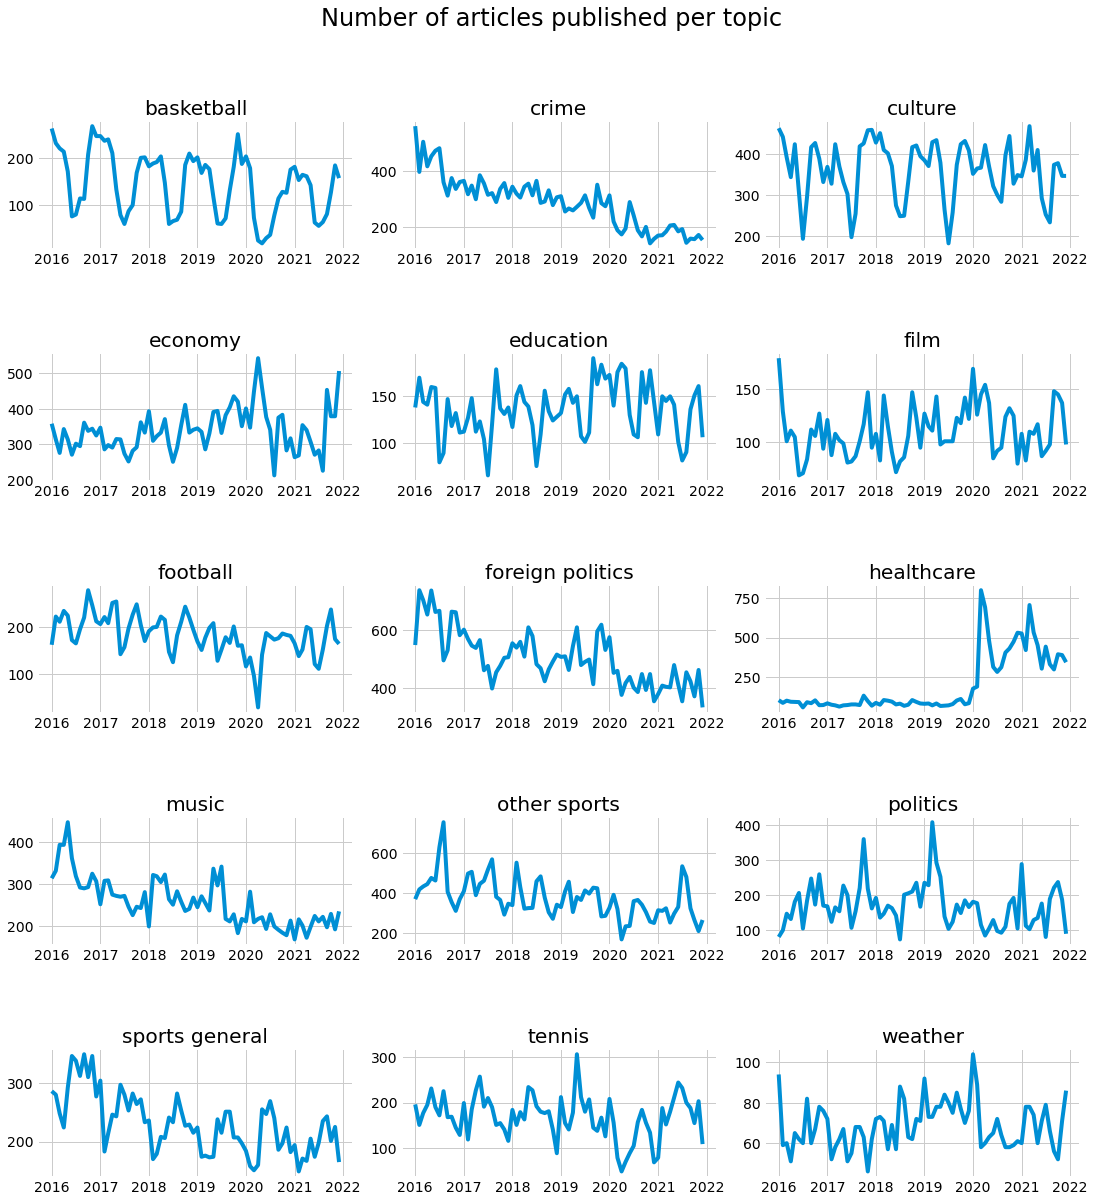

In [26]:
fig, axes = plt.subplots(5, 3, figsize=(15, 15), sharey=False)
axes = axes.flatten()
plt.tight_layout(pad=0, w_pad=1, h_pad=1)
plt.subplots_adjust(wspace=.15, hspace=.8)

data = df.groupby(['publishMonthDt', 'topic_label'], as_index=False)[['id']].count()
data = data.pivot(index='publishMonthDt', columns='topic_label', values='id').fillna(0)

for i, c in enumerate(data.columns):
    axes[i].plot(data[c])
    axes[i].set_title(c)
    
plt.suptitle('Number of articles published per topic', y=1.1, size=24)
plt.savefig('figs/articles-per-topic.png', dpi=200, bbox_inches='tight')
plt.show()

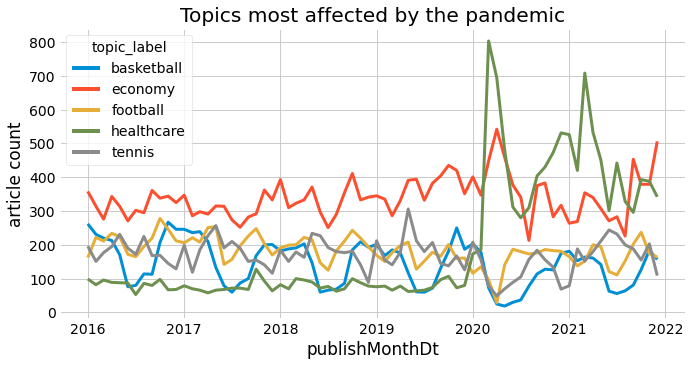

In [27]:
plt.figure(figsize=(10, 5))

topic_list = ['healthcare', 'economy', 'basketball', 'football', 'tennis']
data = df.groupby(['publishMonthDt', 'topic_label'], as_index=False)[['id']].count()
data = data.rename(columns={'id':'article count'})
data = data.loc[data['topic_label'].isin(topic_list)]

sns.lineplot(data=data, x='publishMonthDt', y='article count', hue='topic_label', linewidth = 3)
plt.title('Topics most affected by the pandemic')
plt.savefig('figs/most-affected.png', dpi=200, bbox_inches='tight')
plt.show()

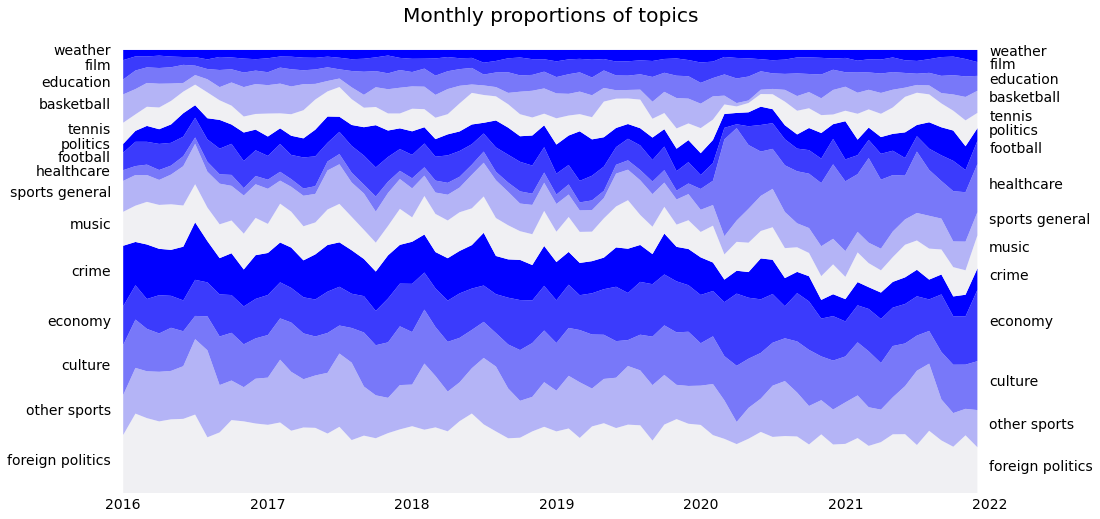

In [28]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1)

data = df.groupby(['publishMonthDt', 'topic_label'], as_index=False)[['id']].count()
data = data.pivot(index='publishMonthDt', columns='topic_label', values='id').fillna(0)
data = data.divide(data.sum(axis=1), axis=0)
data = data[data.sum().sort_values(ascending=False).index]

colors = sns.color_palette('light:b', 5)
plt.stackplot(data.index, data.T, labels=data.columns, colors=colors)

y_pos_right = data.loc['2016-01-01'].cumsum() - (data.loc['2016-01-01']/2)
y_pos_left = data.loc['2021-12-01'].cumsum() - (data.loc['2021-12-01']/2)

for label, y_right, y_left in zip(data.columns, y_pos_right, y_pos_left):
    ax.annotate(label,(dt.datetime(2015, 12, 1), y_right), ha='right')
    ax.annotate(label,(dt.datetime(2021, 12, 31), y_left))

ax.grid(False)
ax.set_yticks([])

plt.title('Monthly proportions of topics')
plt.savefig('figs/proportions.png', dpi=200, bbox_inches='tight')
plt.show()